In [1]:
%matplotlib inline 

import numpy as np
import scipy
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from mpl_toolkits.mplot3d import Axes3D #3D plotting
import datetime as dt # module for manipulating dates and times

import requests 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import binom
from scipy.optimize import minimize_scalar
from __future__ import division
import re
from StringIO import StringIO
from zipfile import ZipFile 
from pandas import read_csv
from urllib import urlopen
import urllib2
import json

import sklearn
import sklearn.preprocessing
import sklearn.datasets

# Gaussian Shocks

### LMSR ACCORDING TO Brahma et al.

In [48]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_gaussian(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shock_sd):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            initialvalue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        if np.random.binomial(1,trueValue[iterations-1]/100) == 1:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        else:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trueValue, MMprice_1, rmse

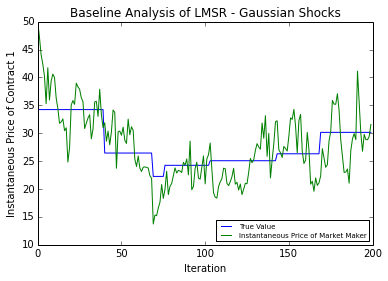

-351.982059808
3571.11947008
-8179.90973845


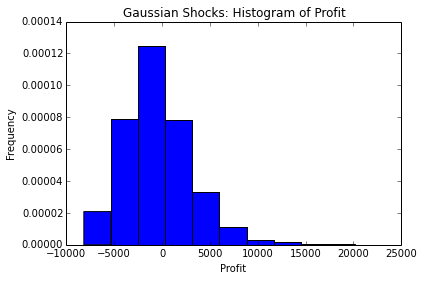

3.68644411874


In [49]:
# Baseline Revenue Results 
trial_1, trueValue, MMprice_1, rmse = runlmsr_gaussian(200, 1000, 125, 20, 1/100, 5)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LMSR - Gaussian Shocks')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit')
plt.show()


print(np.mean(rmse))

In [51]:
beta = [100, 125, 250,500]

for betaspecific in beta:
    # Baseline Revenue Results 
    trial_1, trueValue, MMprice_1, rmse = runlmsr_gaussian(200, 1000, betaspecific, 20, 1/100, 5)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.mean(rmse))

-211.86635515
3019.40870859
-6824.40040685
3.84810621147
-349.287236892
3725.70802921
-8598.1053549
3.69444669952
-877.179261505
6735.16425934
-15771.024595
3.25339541255
-1969.03976835
13384.0818425
-32777.2184502
3.11564394118


### Liquidity Sensitive LMSR Implementation Das Interpretation


In [74]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussian(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            initialValue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        if trueValue[iterations-1]>100:
            trueValue[iterations-1]=100
        elif trueValue[iterations-1]<0:
            trueValue[iterations-1]=0
        if np.random.binomial(1,trueValue[iterations-1]/100) == 1:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        else:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trueValue, MMprice_1, rmse

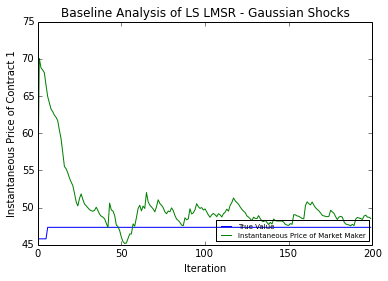

-86511.2438099
74671.1054168
-181114.393956


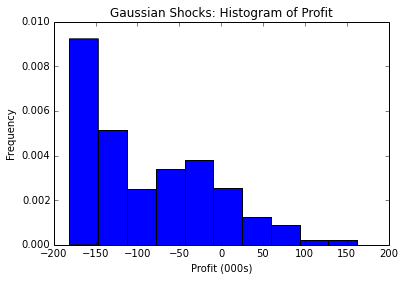

6.41322574737


In [91]:
# Baseline Revenue Results 
#trial_1, trueValue, MMprice_1, rmse = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, 0.3, 1000)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LS LMSR - Gaussian Shocks')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))


plt.hist(trial_1/1000, normed=1)
plt.xlabel('Profit (000s)')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit')
plt.show()

print(np.mean(rmse))

In [76]:
alpha = [0.05, 0.1, 0.3, 0.5]

for alphaspecific in alpha:
    # Baseline Revenue Results 
    trial_1, trueValue, MMprice_1, rmse = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, alphaspecific, 1000)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.mean(rmse))

-100225.059639
8231.28886839
-115280.081222
5.00546829291
-99573.7051308
18113.0925236
-130693.926827
3.64385034504
-84268.5757974
75712.1545739
-182730.142324
6.32049994167
-59501.517875
151726.878761
-232262.522112
15.9364177088


In [77]:
initial = [100,500,1000,5000]

for initialspecific in initial:
    # Baseline Revenue Results 
    trial_1, trueValue, MMprice_1, rmse = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, 0.5, initialspecific)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.mean(rmse))

31986.8500216
113627.820702
-89949.5414702
8.02580870589
-4221.75221182
135198.38481
-157675.405221
12.3340651955
-52422.8014408
154403.894185
-233038.55296
16.1307389944
-471218.205119
191071.281025
-703563.605503
26.8733149271


## Uniform Shock

In [66]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_uniform(iterations, trialnumber, MMb, traderAlphaExponential):
    trial_1 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            initialvalue = trueValue[time-1]
            if time == iterations/2:
                initialValue = initialValue + np.random.uniform(0, 40)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        if trueValue[iterations-1]>100:
            trueValue[iterations-1]=100
        elif trueValue[iterations-1]<0:
            trueValue[iterations-1]=0
        if np.random.binomial(1,trueValue[iterations-1]/100) == 1:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        else:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trueValue, MMprice_1, rmse

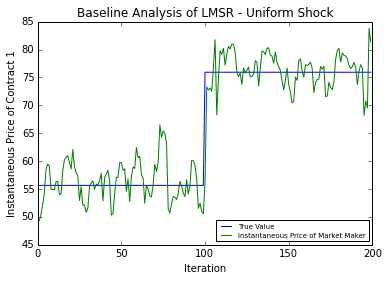

-1852.15080066
5541.59926999
-8663.0896945


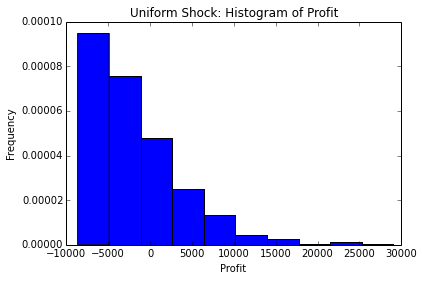

4.41292204986


In [67]:
# Baseline Revenue Results 
trial_1,  trueValue, MMprice_1, rmse = runlmsr_uniform(200, 1000, 125, 20)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LMSR - Uniform Shock')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Uniform Shock: Histogram of Profit')
plt.show()


print(np.mean(rmse))

In [69]:
beta = [10, 125, 250,500]

for betaspecific in beta:
    # Baseline Revenue Results 
    trial_1, trueValue, MMprice_1, rmse = runlmsr_uniform(200, 1000, betaspecific, 20)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.mean(rmse))

-159.845426846
409.334267802
-693.04717556
4.80949711565
-1859.07738985
5906.85298543
-8663.0896945
4.41922516876
-3276.30608252
11387.9009481
-17326.179389
4.82631730383
-5592.844431
24768.3476109
-34588.5897481
5.70027637972


In [79]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_uniform(iterations, trialnumber, traderAlphaExponential, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        difference = np.zeros(iterations)
        
        for time in np.arange(1,iterations,1):
            initialValue = trueValue[time-1]
            if time == iterations/2:
                initialValue = initialValue + np.random.uniform(0, 40)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        if trueValue[iterations-1]>100:
            trueValue[iterations-1]=100
        elif trueValue[iterations-1]<0:
            trueValue[iterations-1]=0
        if np.random.binomial(1,trueValue[iterations-1]/100) == 1:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        else:
            trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)    
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trueValue, MMprice_1, rmse

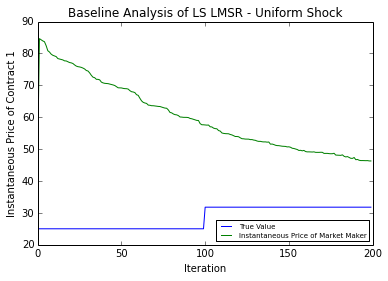

-65627.9984349
97392.3895196
-229366.098546
16.3016904113


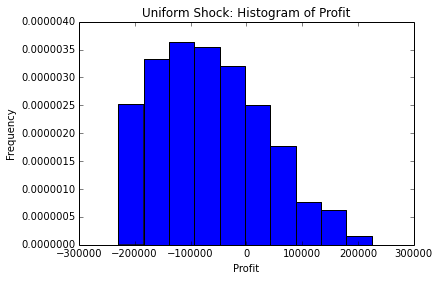

In [80]:
# Baseline Revenue Results 
trial_1, trueValue, MMprice_1,rmse = runlslmsr_uniform(200, 1000, 20, 0.5, 1000)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LS LMSR - Uniform Shock')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Uniform Shock: Histogram of Profit')

print(np.mean(rmse))

In [81]:
alpha = [0.05, 0.1, 0.3, 0.5]

for alphaspecific in alpha:
    # Baseline Revenue Results 
    trial_1, trueValue, MMprice_1, rmse = runlslmsr_uniform(200, 1000, 20, alphaspecific, 1000)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.mean(rmse))

-102650.508048
11759.228823
-116682.585483
5.91655411399
-106598.11187
19064.8147321
-134286.434658
5.67097091333
-101629.975194
46926.0822861
-185007.408141
9.26077483673
-66267.5657874
98986.7075387
-228783.070872
16.4466635851


In [83]:
initial = [100, 500, 1000, 5000]

for initialspecific in initial:
    # Baseline Revenue Results 
    trial_1, trueValue, MMprice_1, rmse = runlslmsr_uniform(200, 1000,20, 0.5, initialspecific)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.mean(rmse))

21359.8319204
72865.7119348
-77259.0172946
8.92631143668
-15944.3790304
88823.0577874
-154675.358958
13.3818447751
-63724.4538284
101949.035378
-228752.365515
16.5663539945
-461608.702696
143456.787645
-699602.660584
23.7030787087


## Proposed LMSR\* model

In [19]:
def runproplmsr_gaussian(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy, window):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue
        
        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0
        
        difference = np.zeros(iterations)
        indic = 0
        #keep track of buy contract 1 or contract 2, buy contract 1 = 1, buy contract 2 = 2, no trade = 3
        buysell = np.zeros(iterations)
        #keep track of how many days since last reset
        counter_reset = 0
        for time in np.arange(1,iterations,1):
            counter_reset += 1
            initialValue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            # http://stackoverflow.com/questions/10711918/python-reduce-to-check-if-all-elements-are-equal
            if time > window:
                historicalwindow = buysell[(time-10):time]
                if (all(e == historicalwindow[0] for e in historicalwindow)) == 1 and counter_reset > window:
                    counter_reset = 0  
                    f = lambda q: (alpha*np.log(np.exp(q/(alpha*(q+initialsubsidy))) + \
                                   np.exp(initialsubsidy/(alpha*(q+initialsubsidy)))) + \
                                   (initialsubsidy*(np.exp(q/(alpha*(q+initialsubsidy))) - \
                                   np.exp(initialsubsidy/(alpha*(q+initialsubsidy))))) / \
                                   ((q+initialsubsidy)*(np.exp(q/(alpha*(q+initialsubsidy))) + \
                                   np.exp(initialsubsidy/(alpha*(q+initialsubsidy))))) - \
                                   (MMprice_1[time-1]/100))
                    newinitialquantity_1 = scipy.optimize.newton(f, initialsubsidy)
                    MMb = alpha*(initialsubsidy + newinitialquantity_1)    
                    currrentquantity_1 = newinitialquantity_1
                    currrentquantity_2 = initialsubsidy
                    indic = 1
                elif counter_reset <= window:
                    Tquantity_1 = np.sum(MMquantity_1[0:(time-counter_reset+1)])
                    Tquantity_2 = np.sum(MMquantity_2[0:(time-counter_reset+1)])
                    MMb = alpha*(currentquantity_1-Tquantity_1+currentquantity_2-Tquantity_2)
                    currentquantity_1 = currentquantity_1 - Tquantity_1 + newinitialquantity_1
                    currentquantity_2 = currentquantity_2 - Tquantity_2 + initialsubsidy
                else:
                    if indic == 1:
                        MMb = alpha*(currentquantity_1 - Tquantity_1 + newinitialquantity_1 + \
                                  currentquantity_2 - Tquantity_2  + initialsubsidy)  
                    else:
                        MMb = alpha*(currentquantity_1 + currentquantity_2)
            else:
                    MMb = alpha*(currentquantity_1 + currentquantity_2)  
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
                buysell[time] = 1
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                buysell[time] = 2
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))

            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

In [20]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1, rmse = runproplmsr_gaussian(200, 1, 20, 1/100, 5, 0.5, 500, 20)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LMSR* - Gaussian Shocks')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit if Outcome 1 Occured')
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Gaussian Shocks: Histogram of Profit if Outcome 2 Occured')
plt.show()

print(np.mean(rmse))

RuntimeError: Failed to converge after 50 iterations, value is nan

### LMSR TEXTBOOK

In [4]:
# LMSR Implementation Textbook Interpretation
def runlmsr_gaussiantextbook(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shockSD):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = 0
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = 0
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            initialvalue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityTrader_1 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_1
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityTrader_2 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_2
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1


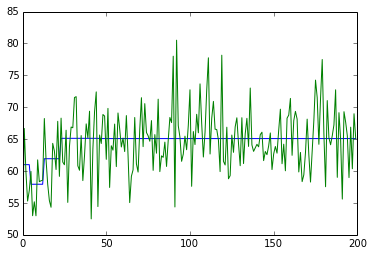

797.336224597
5359.30468355
-8663.0896945


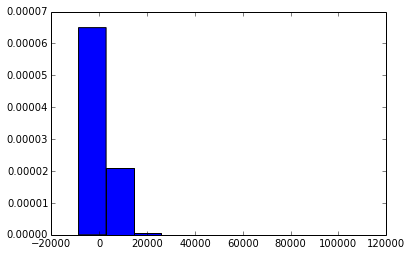

705.597238106
6287.47781319
-8663.0896945


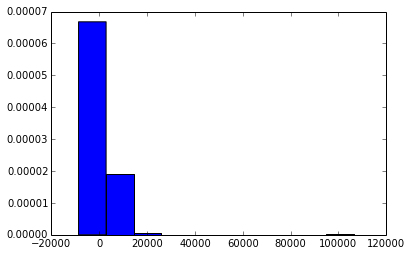

In [5]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlmsr_gaussiantextbook(200, 1000, 125, 20, 1/100, 5)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


### Liquidity sensitive - trying an optimzer to solve for myopic trader

In [2]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussianmyopic(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            initialValue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                f = lambda q: (alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)) + (currentquantity_2*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_2/MMb))) / ((q+currentquantity_2)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)))) - traderValue/100
                res = minimize_scalar(f, method='brent')
                if res.x > 0 and res.success == 1:
                    quantityTrader_1 = min(quantityTrader, res.x)
                else:
                    quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                f = lambda q: (alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)) + (currentquantity_1*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_1/MMb))) / ((q+currentquantity_1)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)))) - traderValue/100
                res = minimize_scalar(f, method='brent', options={'xtol': 0.001})
                if res.x > 0 and res.success == 1:
                    quantityTrader_2 = min(quantityTrader, res.x)
                else:
                    quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1   
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

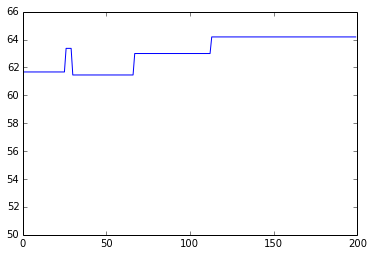

inf
nan
-111.331687048


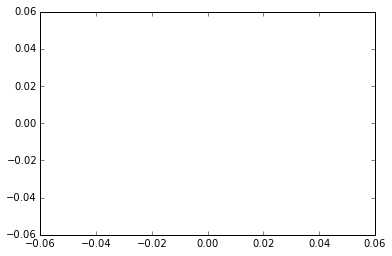

inf
nan
-109.422646291


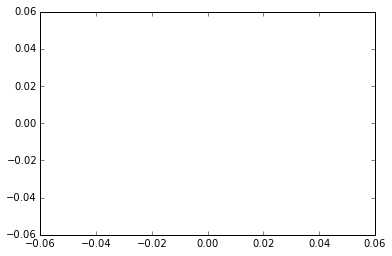

In [3]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlslmsr_gaussianmyopic(200, 1000, 20, 1/100, 5, 0.05, 1)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


## COMBINATION (RUNNING LMSR AT SAME TIME AS LS LMSR)

In [11]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def bothlmsr_gaussian(iterations, trialnumber, typMMb, traderAlphaExponential, shock_prob, shock_sd):
    typtrial_1 = np.zeros(trialnumber)
    typtrial_2 = np.zeros(trialnumber)
    typrmse = np.zeros(trialnumber)
    lstrial_1 = np.zeros(trialnumber)
    lstrial_2 = np.zeros(trialnumber)
    lsrmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        typeMMquantity_1 = np.zeros(iterations)
        typMMprice_1 = np.zeros(iterations)
        typMMprice_1[0] = 50
        lsMMquantity_1 = np.zeros(iterations)
        lsMMprice_1 = np.zeros(iterations)
        lsMMprice_1[0] = 50
        
        #outcome 2
        typMMquantity_2 = np.zeros(iterations)
        typMMprice_2 = np.zeros(iterations)
        typMMprice_2[0] = 50
        lsMMquantity_2 = np.zeros(iterations)
        lsMMprice_2 = np.zeros(iterations)
        lsMMprice_2[0] = 50
        
        #revenue
        typMMpayment = np.zeros(iterations)
        lsMMpayment = np.zeros(iterations)
        
        typdifference = np.zeros(iterations)
        lsdifference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            
            # STANDARD LMSR 
            currentquantity_1 = np.sum(typMMquantity_1)
            currentquantity_2 = np.sum(typMMquantity_2)
            MMb = typMMb
            
            if traderValue > typMMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, typMMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                typMMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, typMMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                typMMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            typMMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            typMMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            typMMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            typdifference[time] = (typMMprice_1[time] - trueValue[time]) ** 2
            
            # LIQUID SENSITIVE LMSR
            currentquantity_1 = np.sum(lsMMquantity_1)
            currentquantity_2 = np.sum(lsMMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            if traderValue > lsMMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                lsMMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                lsMMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            lsMMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            lsMMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            lsMMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            lsdifference[time] = (lsMMprice_1[time] - trueValue[time]) ** 2
        typtrial_1[i] = np.sum(typMMpayment)-100*np.sum(typMMquantity_1)
        typtrial_2[i] = np.sum(typMMpayment)-100*np.sum(typMMquantity_2)
        typrmse[i] = np.sqrt(np.sum(typdifference)/iterations)        
        lstrial_1[i] = np.sum(lsMMpayment)-100*np.sum(lsMMquantity_1)
        lstrial_2[i] = np.sum(lsMMpayment)-100*np.sum(lsMMquantity_2)
        lsrmse[i] = np.sqrt(np.sum(lsdifference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

## Initial Attempt to solve LMSR*

In [ ]:
def runproplmsr_gaussian(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy, window):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue
        
        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0
        
        difference = np.zeros(iterations)
        indic = 0
        #keep track of buy contract 1 or contract 2, buy contract 1 = 1, buy contract 2 = 2, no trade = 3
        buysell = np.zeros(iterations)
        #keep track of how many days since last reset
        counter_reset = 0
        for time in np.arange(1,iterations,1):
            counter_reset += 1
            initialValue = trueValue[time-1]
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            # http://stackoverflow.com/questions/10711918/python-reduce-to-check-if-all-elements-are-equal
            if time > window:
                historicalwindow = buysell[(time-10):time]
                if (all(e == historicalwindow[0] for e in historicalwindow)) == 1 and counter_reset > window:
                    counter_reset = 0  
                    f = lambda q: (alpha*np.log(np.exp(q/(alpha*(q+initialsubsidy))) + \
                                   np.exp(initialsubsidy/(alpha*(q+initialsubsidy)))) + \
                                   (initialsubsidy*(np.exp(q/(alpha*(q+initialsubsidy))) - \
                                   np.exp(initialsubsidy/(alpha*(q+initialsubsidy))))) / \
                                   ((q+initialsubsidy)*(np.exp(q/(alpha*(q+initialsubsidy))) + \
                                   np.exp(initialsubsidy/(alpha*(q+initialsubsidy))))) - \
                                   (MMprice_1[time-1]/100))
                    newinitialquantity_1 = scipy.optimize.newton(f, initialsubsidy)
                    MMb = alpha*(initialsubsidy + newinitialquantity_1)    
                    currrentquantity_1 = newinitialquantity_1
                    currrentquantity_2 = initialsubsidy
                    indic = 1
                elif counter_reset <= window:
                    Tquantity_1 = np.sum(MMquantity_1[0:(time-counter_reset+1)])
                    Tquantity_2 = np.sum(MMquantity_2[0:(time-counter_reset+1)])
                    MMb = alpha*(currentquantity_1-Tquantity_1+currentquantity_2-Tquantity_2)
                    currentquantity_1 = currentquantity_1 - Tquantity_1 + newinitialquantity_1
                    currentquantity_2 = currentquantity_2 - Tquantity_2 + initialsubsidy
                else:
                    if indic == 1:
                        MMb = alpha*(currentquantity_1 - Tquantity_1 + newinitialquantity_1 + \
                                  currentquantity_2 - Tquantity_2  + initialsubsidy)  
                    else:
                        MMb = alpha*(currentquantity_1 + currentquantity_2)
            else:
                    MMb = alpha*(currentquantity_1 + currentquantity_2)  
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
                buysell[time] = 1
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                buysell[time] = 2
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))

            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
            if MMprice_1[time]>100 or MMprice_2[time]>100:
                MMquantity_1[time] = 0
                MMquantity_2[time] = 0
                MMprice_1[time] = MMprice_1[time-1]
                MMprice_2[time] = MMprice_1[time-1]
                MMpayment[time] = 0
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse